
# 01 — Baseline Emotion Classifier (GoEmotions, **Multi‑label Corrected**)

**Why this notebook?**  
GoEmotions is **multi‑label** (a sentence can have several emotions).  
This notebook fixes the error you saw by binarizing labels and using a multi‑label classifier.


What the notebook does (in order)

Checks your environment — prints your Python path (should end in /emotion/bin/python).

Loads GoEmotions (simplified) — downloads the dataset.

Converts to pandas — shows a few rows of text + labels (each label list = multiple emotions).

Binarizes labels — turns lists like [1, 3] into binary rows for each emotion column.

Trains — fits the TF-IDF + One-vs-Rest Logistic Regression model.

Evaluates — prints a big classification_report with precision/recall/F1 for each emotion.

Optionally shows top-k evaluation & confusion matrices.

Saves the model to models/tfidf_logreg_goemotions_multilabel.joblib

In [13]:

# --- Environment sanity check ---
import sys
print("Python executable:", sys.executable)


Python executable: /Users/jp/miniforge3/envs/emotion/bin/python


In [14]:

# --- Ensure 'datasets' is available ---
import sys, subprocess, pkgutil
if pkgutil.find_loader("datasets") is None:
    print("Installing 'datasets'...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "datasets"])
else:
    print("'datasets' already installed.")


'datasets' already installed.


In [15]:

# --- Load GoEmotions (simplified) ---
from datasets import load_dataset
ds = load_dataset("go_emotions", "simplified")
ds


DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

In [16]:

# --- Convert to pandas ---
import pandas as pd
train_df = pd.DataFrame({"text": ds["train"]["text"], "label": ds["train"]["labels"]})
test_df  = pd.DataFrame({"text": ds["test"]["text"],  "label": ds["test"]["labels"]})

print("Train:", train_df.shape, " Test:", test_df.shape)
train_df.head()


Train: (43410, 2)  Test: (5427, 2)


,text,label
0,My favourite food is anything I didn't have to...,[27]
1,"Now if he does off himself, everyone will thin...",[27]
2,WHY THE FUCK IS BAYLESS ISOING,[2]
3,To make her feel threatened,[14]
4,Dirty Southern Wankers,[3]


In [17]:

# --- Binarize multi‑label targets ---
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_df["label"])  # shape: (n_samples, n_classes)
y_test  = mlb.transform(test_df["label"])

print("Classes:", list(mlb.classes_))
print("y_train shape:", y_train.shape, " y_test shape:", y_test.shape)


Classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27)]
y_train shape: (43410, 28)  y_test shape: (5427, 28)


In [18]:

# --- Build multi‑label pipeline: TF‑IDF + One‑vs‑Rest Logistic Regression ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1,2),
        max_features=50_000
    )),
    ("clf", OneVsRestClassifier(LogisticRegression(max_iter=1500)))
])
model


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [19]:

# --- Train ---
model.fit(train_df["text"], y_train)
print("Training complete.")


Training complete.


In [20]:

# --- Evaluate (threshold at 0.5) ---
import numpy as np
from sklearn.metrics import classification_report, multilabel_confusion_matrix

y_proba = model.predict_proba(test_df["text"])
y_pred = (y_proba >= 0.5).astype(int)

print(classification_report(
    y_test, y_pred,
    target_names=[str(c) for c in mlb.classes_]
))


              precision    recall  f1-score   support

           0       0.71      0.35      0.47       504
           1       0.81      0.55      0.65       264
           2       0.63      0.13      0.22       198
           3       0.53      0.03      0.05       320
           4       0.64      0.07      0.12       351
           5       0.78      0.10      0.18       135
           6       0.44      0.03      0.05       153
           7       0.80      0.03      0.05       284
           8       0.67      0.14      0.24        83
           9       1.00      0.01      0.01       151
          10       0.27      0.01      0.02       267
          11       0.74      0.16      0.27       123
          12       1.00      0.03      0.05        37
          13       0.91      0.10      0.18       103
          14       0.86      0.15      0.26        78
          15       0.95      0.84      0.89       352
          16       0.00      0.00      0.00         6
          17       0.60    

/Users/jp/miniforge3/envs/emotion/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/jp/miniforge3/envs/emotion/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


For data table:

Metric	What it means (in this multi-label context)

precision	“When the model predicted this emotion, how often was it right?”

recall	“Out of all texts that truly had this emotion, how many did we catch?”

f1-score	Harmonic mean of precision and recall — good single-number summary

support	How many examples of that emotion existed in the test set

For averages:

- micro

Pools all TP, FP, FN across all classes.

Only present in multi-label if average='micro' passed manually
(not shown here by defauly, because "classification_report() prints iy only for multi-class problems).

- macro

Mean of per-class metrics (treats all emotions equally).

Always present in multi-label, and always
shown.

- weighted

Mean of per-class metrics weighted by support (common classes count more).

Always present in multi-label, and always
shown.

- samples

Average of per-sample F1s (how good the set of predicted labels per sentence was).

Always present in this multi-label, but only exists for multi-label tasks.




In [21]:

# --- Optional: top‑k predictions per sample ---
import numpy as np
from sklearn.metrics import classification_report

k = 1  # try k=1 or k=2
y_pred_topk = np.zeros_like(y_proba, dtype=int)
topk_idx = np.argpartition(-y_proba, kth=k-1, axis=1)[:, :k]
rows = np.arange(y_proba.shape[0])[:, None]
y_pred_topk[rows, topk_idx] = 1

print(f"Top‑k (k={k}) report:")
print(classification_report(
    y_test, y_pred_topk,
    target_names=[str(c) for c in mlb.classes_]
))


Top‑k (k=1) report:
              precision    recall  f1-score   support

           0       0.64      0.54      0.59       504
           1       0.80      0.73      0.76       264
           2       0.57      0.22      0.31       198
           3       0.51      0.11      0.18       320
           4       0.49      0.13      0.21       351
           5       0.56      0.10      0.17       135
           6       0.48      0.10      0.17       153
           7       0.68      0.05      0.09       284
           8       0.57      0.19      0.29        83
           9       0.50      0.03      0.06       151
          10       0.37      0.06      0.10       267
          11       0.70      0.27      0.39       123
          12       0.67      0.05      0.10        37
          13       0.76      0.18      0.30       103
          14       0.81      0.33      0.47        78
          15       0.96      0.88      0.91       352
          16       0.00      0.00      0.00         6
       

/Users/jp/miniforge3/envs/emotion/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


runs the same classification report again, but using those top-k predictions instead of the fixed 0.5 probability cutoff

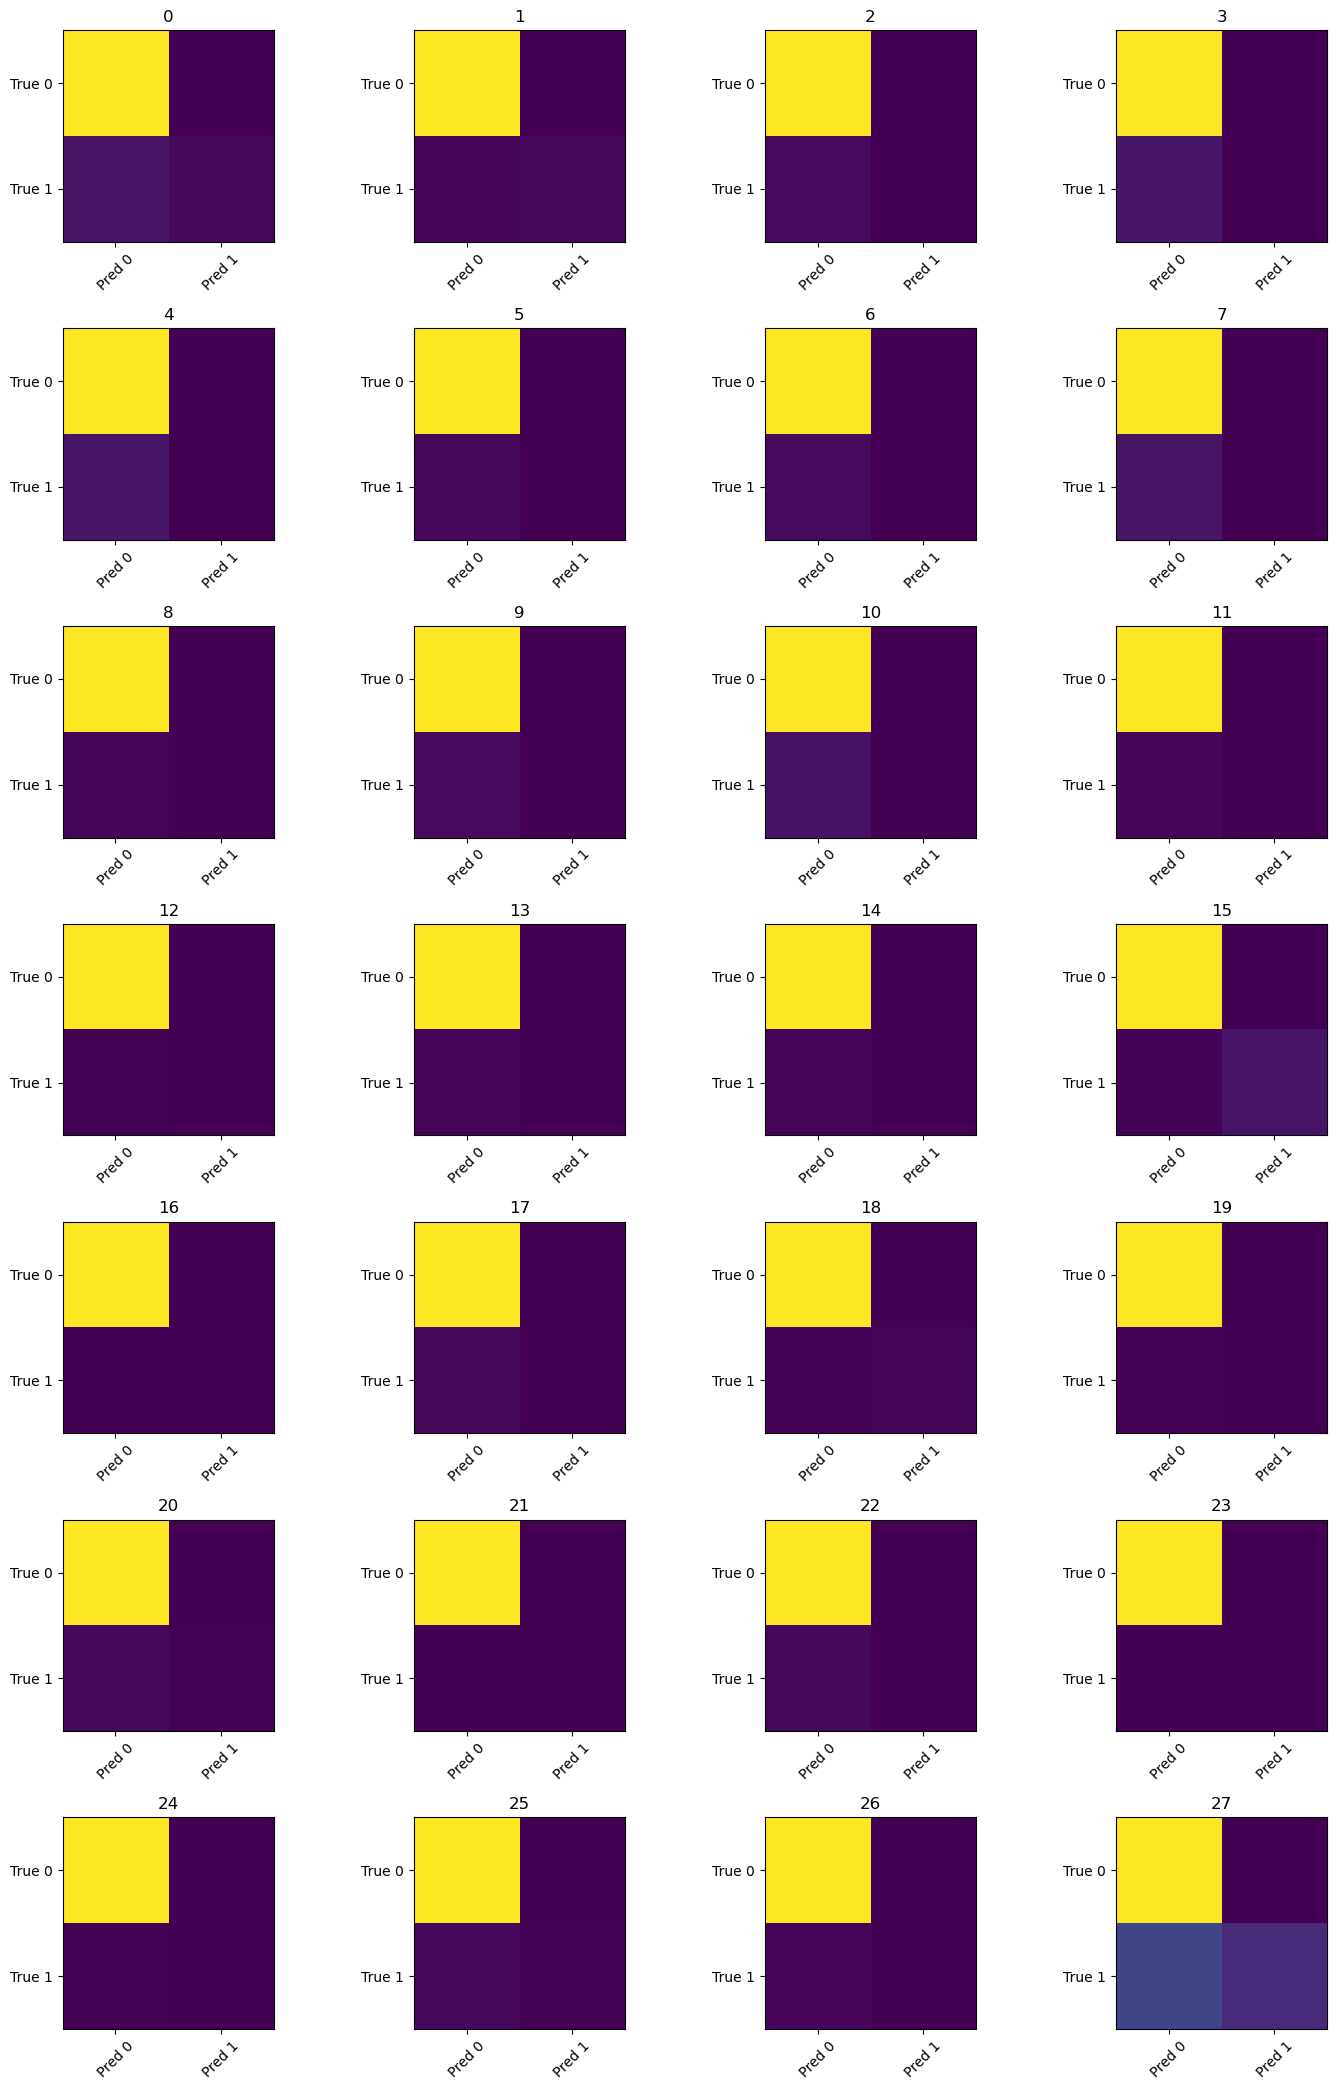

In [22]:

# --- Per‑label confusion matrices (matplotlib only) ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(y_test, y_pred, labels=np.arange(len(mlb.classes_)))

num_labels = len(mlb.classes_)
cols = 4
rows = int(np.ceil(num_labels / cols))
plt.figure(figsize=(4*cols, 3*rows))

for i, cm in enumerate(mcm):
    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(cm, interpolation='nearest')
    ax.set_title(str(mlb.classes_[i]))
    ax.set_xticks([0,1]); ax.set_xticklabels(["Pred 0","Pred 1"], rotation=45)
    ax.set_yticks([0,1]); ax.set_yticklabels(["True 0","True 1"])
    plt.tight_layout()

plt.show()


Each small square plot = the confusion matrix for one emotion label

- TP (bottom-right) = texts that truly had the emotion and were predicted as such
- TN (top-left) = texts that didn’t have it and weren’t predicted as such
- FP (top-right) = model said the emotion was present but it wasn’t
- FN (bottom-left) = model missed it

Because most sentences have only a few emotions and many emotions are rare, almost all cells are true negatives — the model usually says “no” correctly.
That’s why every square looks the same and the top-left corner glows yellow (many TNs).

In [23]:

# --- Save the trained pipeline ---
import joblib
from pathlib import Path

Path("models").mkdir(parents=True, exist_ok=True)
joblib.dump(model, "models/tfidf_logreg_goemotions_multilabel.joblib")
print("Saved -> models/tfidf_logreg_goemotions_multilabel.joblib")


Saved -> models/tfidf_logreg_goemotions_multilabel.joblib


In [24]:

# --- Inference helper: map predictions back to label indices ---
import numpy as np

examples = [
    "i'm so thrilled to see you",
    "this makes me furious",
    "i feel really down today",
    "i'm anxious but hopeful"
]

proba = model.predict_proba(examples)
pred = (proba >= 0.5).astype(int)
pred_label_ids = [np.where(row==1)[0].tolist() for row in pred]
print("Predicted label IDs:", pred_label_ids)


Predicted label IDs: [[27], [], [], []]



## ✅ Summary
- GoEmotions is **multi‑label**; a sentence may have several emotions.  
- We used **MultiLabelBinarizer** + **One‑vs‑Rest Logistic Regression** to model that correctly.  
- You can evaluate with a fixed probability threshold or **top‑k** selection.
